In [1]:
### IMPORTS
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from time import time

%matplotlib inline

In [2]:
### CONSTANTS

# Calibration constants
CALIBRATION_IMAGES = 'camera_cal/calibration*.jpg'
CALIBRATION_PARAMS = 'camera_cal/wide_dist_pickle.p'
NX = 9 # the number of inside corners in x
NY = 6 # the number of inside corners in y

# Finding lines parameters
# Choose the number of sliding windows
NWINDOWS = 9
# Set the width of the windows +/- margin
SLIDING_WINDOW_MARGIN = 100
# Set minimum number of pixels found to recenter window
RECENTER_WINDOW_MINPIX = 50

# Road params to estimate curvature and distance from center
ROAD_WIDTH = 3.7
X_PIX_2_METERS = 3.7/700
Y_PIX_2_METERS = 30/720

## Camera calibration

In [3]:
#\---> Calibration function <-------------------------------------------------\#

def calibrate_camera():
    '''
    Calibrates camera and returns mtx and dist matrixes
    '''
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((NY*NX,3), np.float32)
    objp[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(CALIBRATION_IMAGES)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (NX,NY), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    
    return mtx, dist

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
mtx, dist = calibrate_camera()
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open(CALIBRATION_PARAMS, "wb" ) )

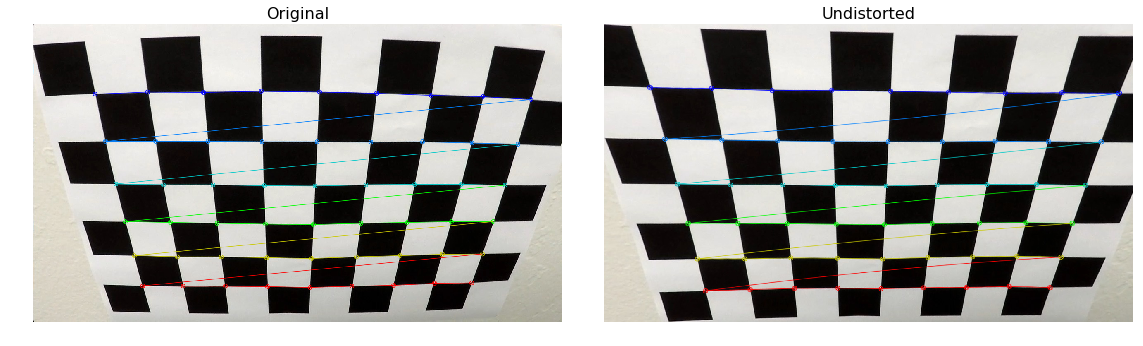

In [4]:
#\---> Calibration example <--------------------------------------------------\#

paths = glob.glob(CALIBRATION_IMAGES)
paths = ['camera_cal/calibration2.jpg']
for fname in paths:
    original = mpimg.imread(fname)
    gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (NX,NY), None)
    if ret:
        corners = cv2.drawChessboardCorners(original, (NX,NY), corners, ret)
        undst = cv2.undistort(corners, mtx, dist, None, mtx)
        break

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

ax_tit = ax1.set_title('Original', fontsize=16)
ax_img = ax1.imshow(corners)
ax_axis = ax1.axis('off')

ax_tit = ax2.set_title('Undistorted', fontsize=16)
ax_img = ax2.imshow(undst)
ax_axis = ax2.axis('off')

fig.savefig('report-images/calibration-example')

## Distortion correction

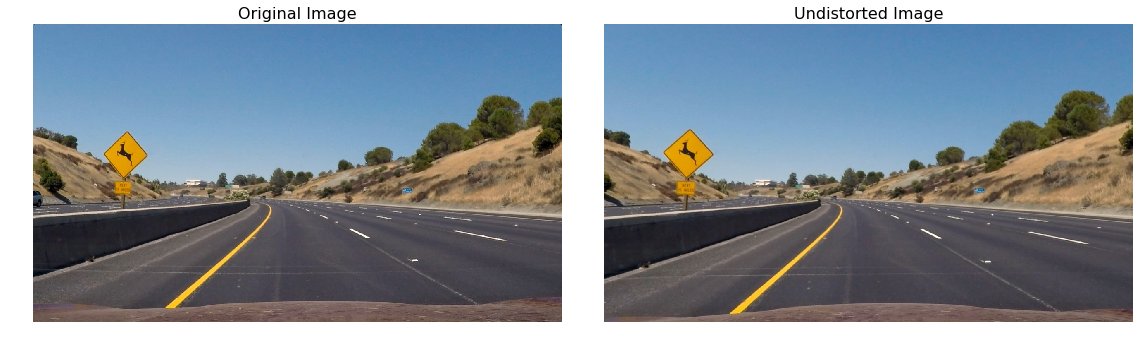

In [5]:
#\---> Distortion correction <------------------------------------------------\#

# Load calibration data
with open(CALIBRATION_PARAMS, mode='rb') as f:
    params = pickle.load(f)
mtx = params["mtx"]
dist = params["dist"]

# Create lambda function to simplify use
undistort = lambda x: cv2.undistort(x, mtx, dist, None, mtx)

#\---> Distortion correction example <----------------------------------------\#

# Load sample image
original = mpimg.imread('test_images/test2.jpg')
img_size = (original.shape[1], original.shape[0])
undist = undistort(original)

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

tit_ax1 = ax1.set_title('Original Image', fontsize=16)
ax1.imshow(original)
ax_axis = ax1.axis('off')

tit_ax2 = ax2.set_title('Undistorted Image', fontsize=16)
ax2.imshow(undist)
ax_axis = ax2.axis('off')

fig.savefig('report-images/un-distortion-example')

## Color an gradient threshold

In [6]:
#\---> Color and gradient threshold function <--------------------------------\#

def color_gradient_threshold(image,
                             s_threshold = (255, 255),
                             r_threshold = (220, 255),
                             l_threshold = (210, 255),
                             b_threshold = (155, 255),                             
                             grad_threshold = (25, 100)):

    # Channels
    R = image[:,:,0]
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    L = luv[:,:,0]
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    B = lab[:,:,2]
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Color threshold
    r_binary = np.zeros_like(R)
    r_binary[(R > r_threshold[0]) & (R <= r_threshold[1])] = 1
    
    s_binary = np.zeros_like(S)
    s_binary[(S > s_threshold[0]) & (S <= s_threshold[1])] = 1

    l_binary = np.zeros_like(L)
    l_binary[(L > l_threshold[0]) & (L <= l_threshold[1])] = 1
    
    b_binary = np.zeros_like(S)
    b_binary[(B > b_threshold[0]) & (B <= b_threshold[1])] = 1
    
    combined_color_binary = np.zeros_like(s_binary)
    combined_color_binary[(r_binary == 1) | (s_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1    
    
    # Sobel x
    sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= grad_threshold[0]) & (scaled_sobel <= grad_threshold[1])] = 1
    
    # Combine binaries
    combined_color_grad_binary = np.zeros_like(s_binary)
    combined_color_grad_binary[(combined_color_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_color_grad_binary

# Create lambda function to simplify use
threshold = lambda x: color_gradient_threshold(x, 
                                               s_threshold = (255, 255), r_threshold = (220, 255), 
                                               l_threshold = (210, 255), b_threshold = (155, 255),
                                               grad_threshold = (25, 100))

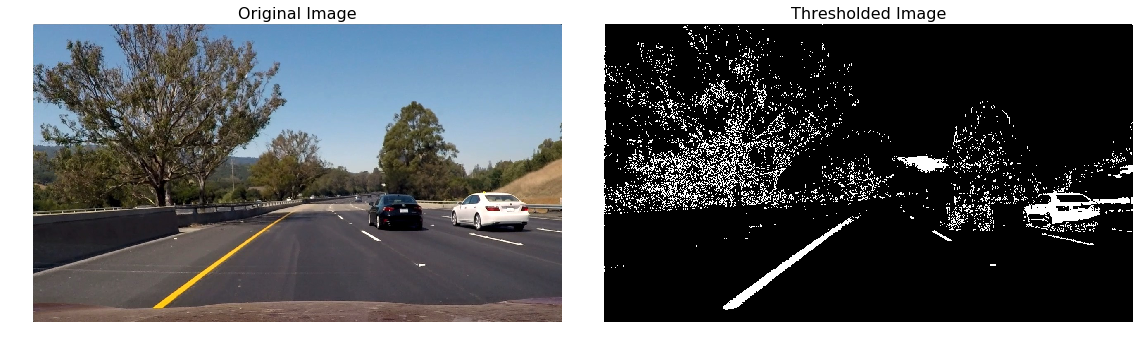

In [7]:
#\---> Color and gradient threshold example <---------------------------------\#

# Load sample image
original = mpimg.imread('test_images/test6.jpg')
thresholded = threshold(original)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

tit_ax1 = ax1.set_title('Original Image', fontsize=16)
ax1.imshow(original)
ax_axis = ax1.axis('off')

tit_ax2 = ax2.set_title('Thresholded Image', fontsize=16)
ax2.imshow(thresholded, cmap='gray')
ax_axis = ax2.axis('off')

fig.savefig('report-images/threshold-example')

## Perspective transformation

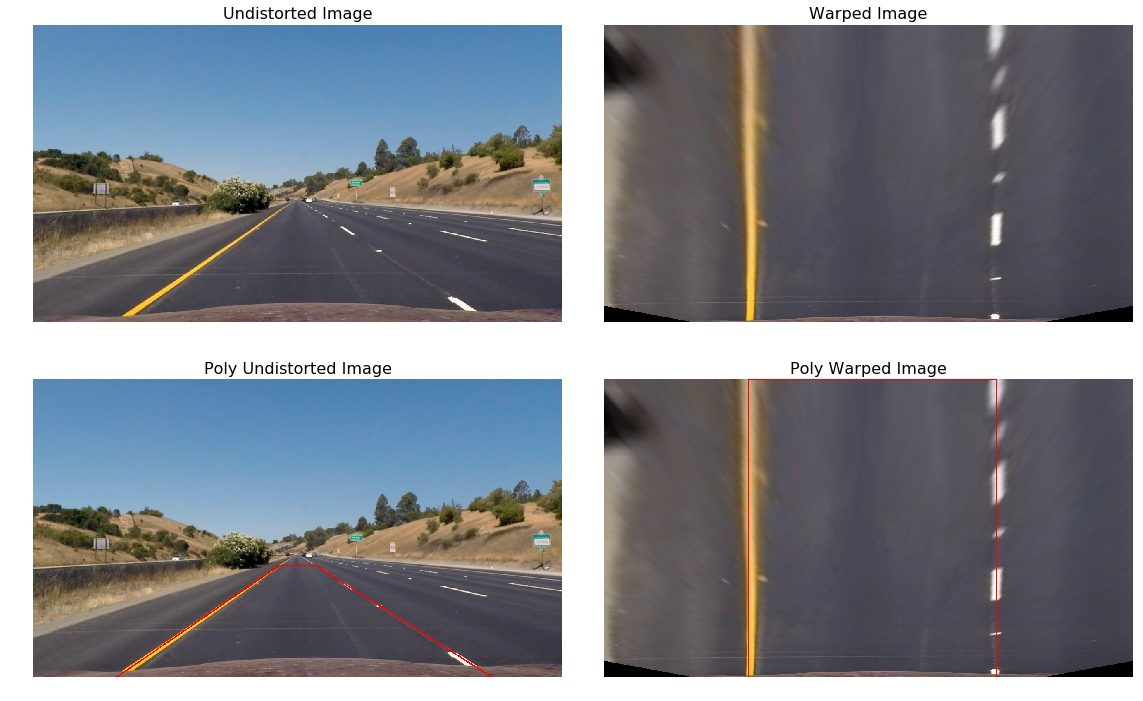

In [8]:
#\---> Perspective transformation function <----------------------------------\#

# Original
original = mpimg.imread('test_images/straight_lines1.jpg')
image_size = (original.shape[1], original.shape[0])

# Data for perspective transform
src = np.float32([[202,720],[1110,720],[684,450],[596,450]])
src_array = np.array(src, np.int32)
src_array.reshape((-1,1,2))

dst = np.float32([[350,720],[950,720],[950,0],[350,0]])
dst_array = np.array(dst, np.int32)
dst_array.reshape((-1,1,2))

# Undistorted
undst = np.copy(original)
undst = cv2.undistort(undst, mtx, dist, None, mtx)

# Draw polylines in undistorted image
poly_undst = np.copy(undst)
poly_undst = cv2.polylines(poly_undst,[src_array],True,(255,0,0), thickness = 2)

# Calc matrix for perspective transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Create lambda function to simplify use
warp = lambda x: cv2.warpPerspective(x, M, image_size)

# Birds eye transformation
warped = warp(undst)

# Draw polylines in Birds eye view
poly_warped = np.copy(warped)
poly_warped = cv2.polylines(poly_warped, [dst_array], True, (255,0,0), thickness = 2)

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))
fig.tight_layout()

tit_ax1 = ax1.set_title('Undistorted Image', fontsize=16)
img_ax = ax1.imshow(undst)
ax_axis = ax1.axis('off')

tit_ax3 = ax3.set_title('Poly Undistorted Image', fontsize=16)
img_ax = ax3.imshow(poly_undst)
ax_axis = ax3.axis('off')

tit_ax2 = ax2.set_title('Warped Image', fontsize=16)
img_ax = ax2.imshow(warped)
ax_axis = ax2.axis('off')

tit_ax4 = ax4.set_title('Poly Warped Image', fontsize=16)
img_ax = ax4.imshow(poly_warped)
ax_axis = ax4.axis('off')

fig.savefig('report-images/birds-eye-transformation')

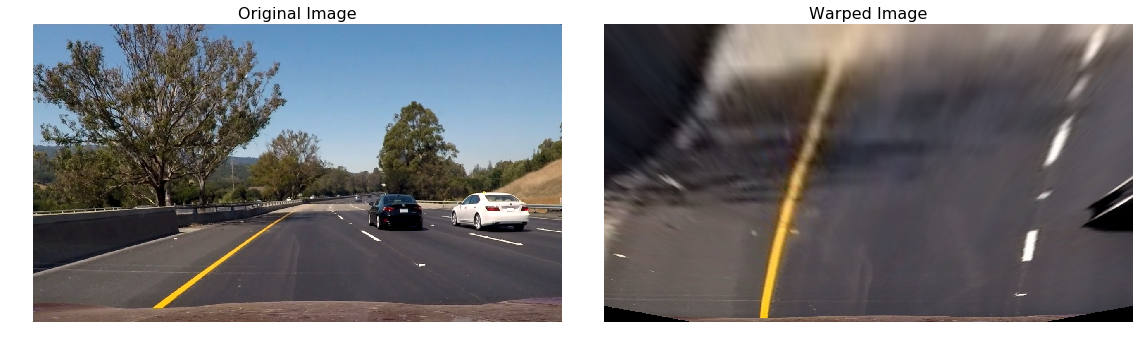

In [9]:
#\---> Color and gradient threshold example <---------------------------------\#

# Load sample image
original = mpimg.imread('test_images/test6.jpg')
warped = warp(original)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

tit_ax1 = ax1.set_title('Original Image', fontsize=16)
ax1.imshow(original)
ax_axis = ax1.axis('off')

tit_ax2 = ax2.set_title('Warped Image', fontsize=16)
ax2.imshow(warped, cmap='gray')
ax_axis = ax2.axis('off')

fig.savefig('report-images/warp-example')

## Transformation pipeline

In [10]:
#\---> Image pipeline function <----------------------------------------------\#

def pipeline(image, fns = [undistort, threshold, warp], return_pipeline = False):
    '''
    Applies a sequence of tranformation functions to the input image
    Returns result and optionally transformation sequence
    '''
    # Data
    x = np.copy(image)
    image_size = (image.shape[1], image.shape[0])
    
    # Apply transformations
    image_pipeline = []
    for fn in fns:
        image_pipeline.append(x)
        x = np.copy( fn(x) )
    
    image_pipeline.append(x)
    
    if return_pipeline:
        return x, image_pipeline
    else:
        return x

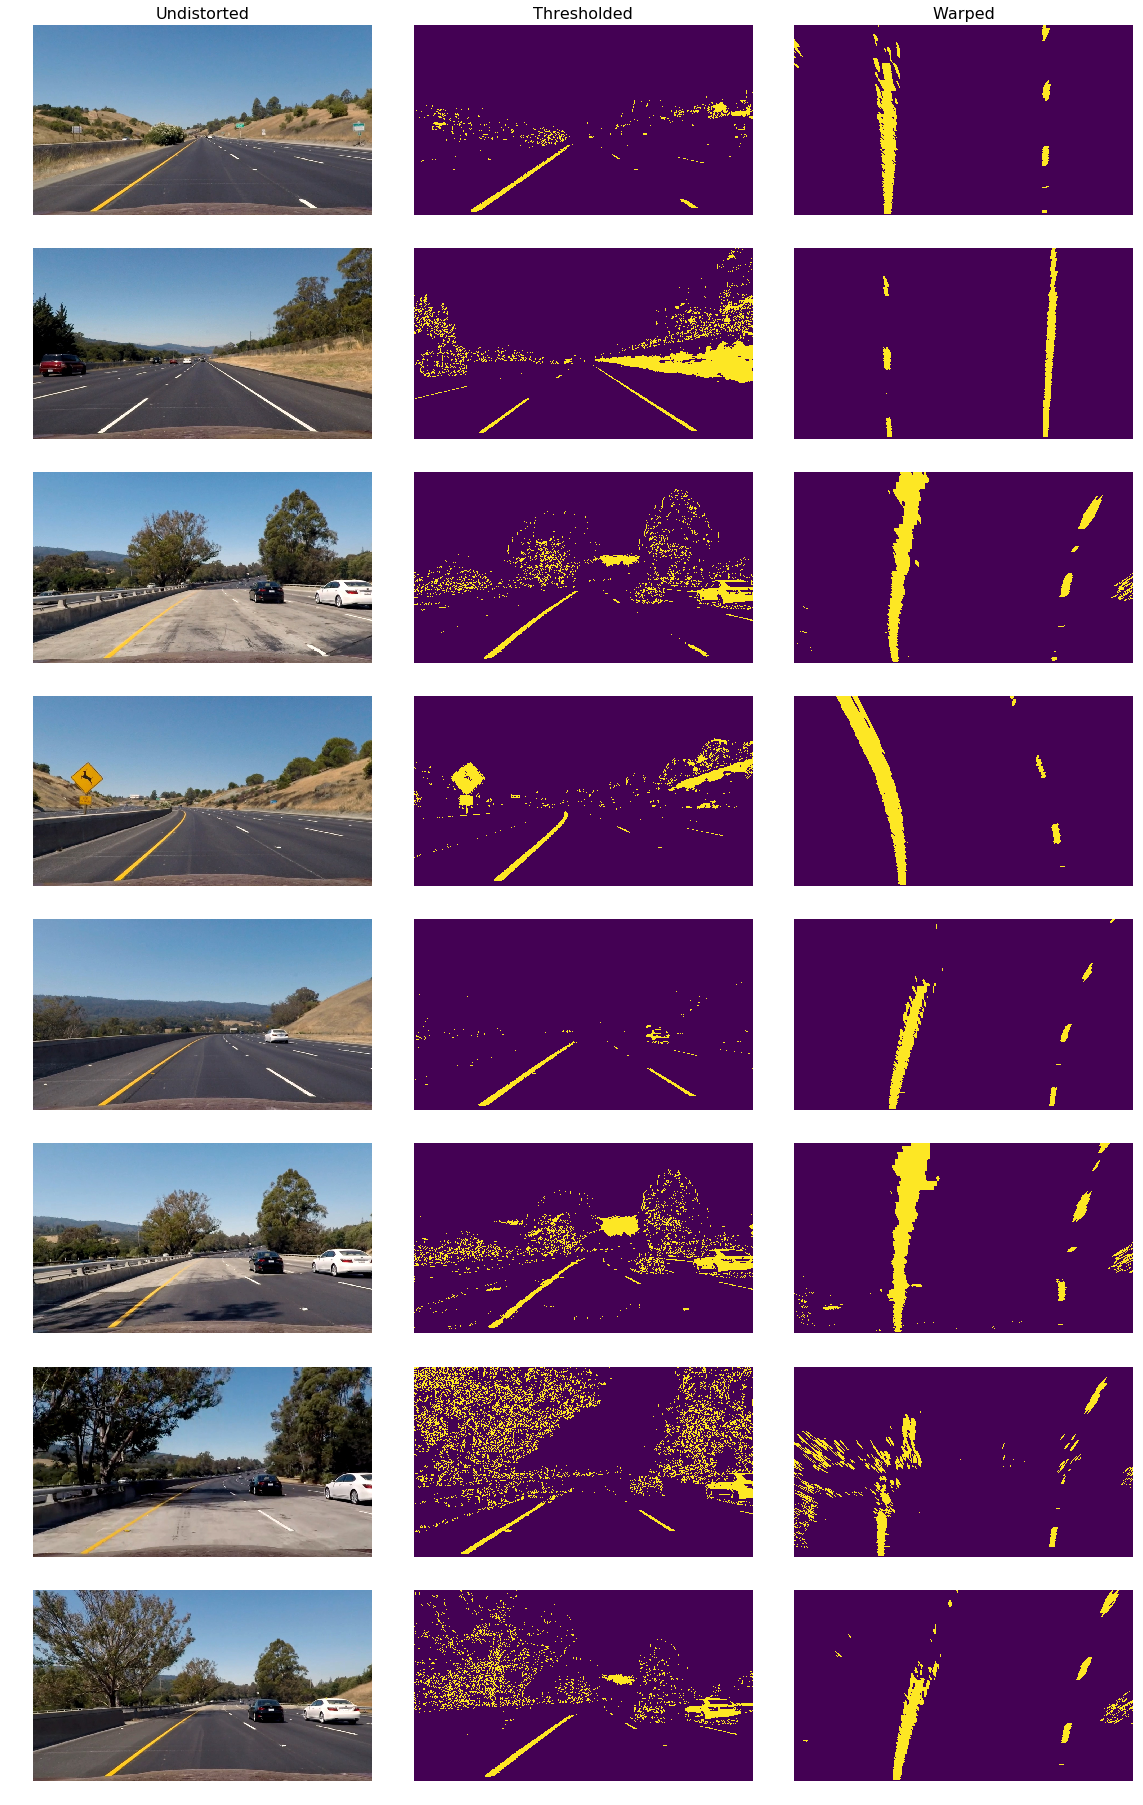

In [11]:
#\---> Image pipeline example <-----------------------------------------------\#

dir_name = 'test_images/'
test_images = ['straight_lines1.jpg', 'straight_lines2.jpg',
               'test1.jpg', 'test2.jpg','test3.jpg','test4.jpg','test5.jpg','test6.jpg']

fig, axes = plt.subplots(8, 3, figsize=(16,25))
fig.tight_layout()

print_title = True
for path, plot_line in zip(test_images, axes):
    original = mpimg.imread(dir_name+path)
    result, image_pipeline = pipeline(original, return_pipeline = True) 
    for image, title, ax in zip(image_pipeline[1:], ['Undistorted', 'Thresholded', 'Warped'], plot_line):
        if print_title:
            tit_ax = ax.set_title(title, fontsize=16)
        ax_img = ax.imshow(image)
        ax_axis = ax.axis('off')
    print_title = False
    
fig.savefig('report-images/transformation_pipeline')

## Line detection

In [12]:
#\---> Line detection function <----------------------------------------------\#

def find_lines(warped, return_image = False):
    '''
    Line detection function using sliding window method
    '''
    # Find starting points of left and right lines
    # We'll use bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((warped, warped, warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    window_height = np.int(warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - SLIDING_WINDOW_MARGIN
        win_xleft_high = leftx_current + SLIDING_WINDOW_MARGIN
        win_xright_low = rightx_current - SLIDING_WINDOW_MARGIN
        win_xright_high = rightx_current + SLIDING_WINDOW_MARGIN
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > RECENTER_WINDOW_MINPIX:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > RECENTER_WINDOW_MINPIX:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # In case the image is not requested return only lines
    if not return_image:
        return (left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit)        
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Return only lines or lines + image
    return out_img, (left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit)

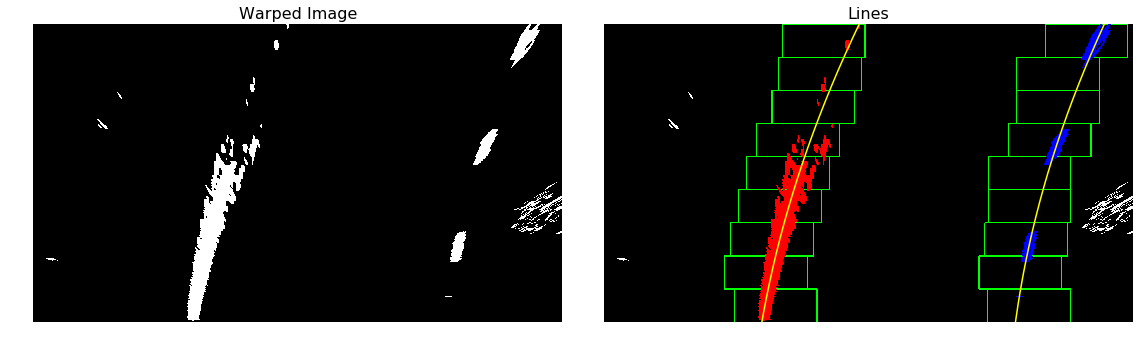

In [13]:
#\---> Line detection example <-----------------------------------------------\#

# Load sample image
original = mpimg.imread('test_images/test6.jpg')
warped = pipeline(original, fns = [undistort, threshold, warp])
lines, (left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit) = find_lines(warped, return_image = True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

tit_ax1 = ax1.set_title('Warped Image', fontsize=16)
ax1.imshow(warped, cmap='gray')
ax_axis = ax1.axis('off')

tit_ax2 = ax2.set_title('Lines', fontsize=16)
ax_img = ax2.imshow(lines)
ax_img = ax2.plot(left_fitx, ploty, color='yellow')
ax_img = ax2.plot(right_fitx, ploty, color='yellow')
ax_axis = ax2.axis('off')

fig.savefig('report-images/line-detection-sldwnd')

In [14]:
#\---> Line detection function <----------------------------------------------\#

def find_lines_assisted(warped, left_fit, right_fit, return_image = False):
    '''
    Line detection base on previously detected lines
    '''
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # you can base the pixel detection based on previous lines
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_fitx = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ((nonzerox > (left_fitx - SLIDING_WINDOW_MARGIN)) &
                      (nonzerox < (left_fitx + SLIDING_WINDOW_MARGIN))) 
    right_lane_inds = ((nonzerox > (right_fitx - SLIDING_WINDOW_MARGIN)) &
                       (nonzerox < (right_fitx + SLIDING_WINDOW_MARGIN)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Check if enough pixels found to fit a polynomial, if not use sliding window approach
    if len(leftx) < 350 or len(rightx) < 350:
        return find_lines(warped, return_image = return_image)
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # In case the image is not requested
    if not return_image:
        return (left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-SLIDING_WINDOW_MARGIN, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+SLIDING_WINDOW_MARGIN, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-SLIDING_WINDOW_MARGIN, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+SLIDING_WINDOW_MARGIN, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return out_img, (left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit)

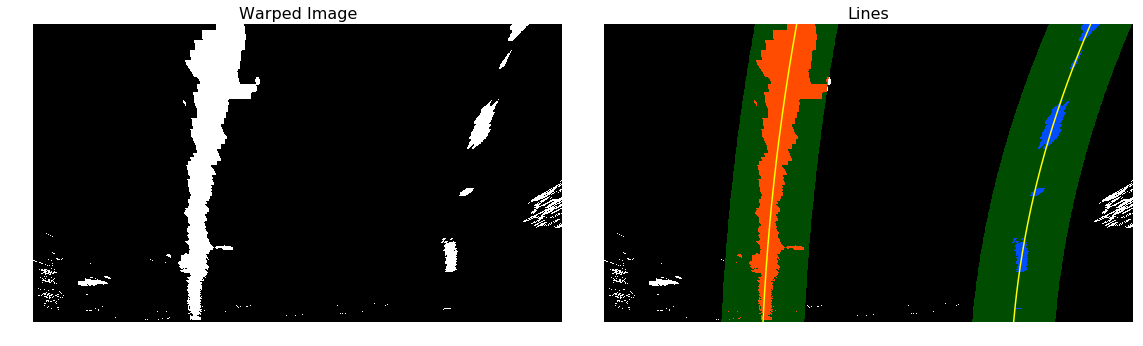

In [15]:
#\---> Line detection example <-----------------------------------------------\#

original = mpimg.imread('test_images/test4.jpg')
warped = pipeline(original)
(left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit) = find_lines(warped)

next_original = mpimg.imread('test_images/test5.jpg')
warped = pipeline(original)
lines, (left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit) = \
    find_lines_assisted(warped, left_fit, right_fit, return_image = True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

tit_ax1 = ax1.set_title('Warped Image', fontsize=16)
ax1.imshow(warped, cmap='gray')
ax_axis = ax1.axis('off')

tit_ax2 = ax2.set_title('Lines', fontsize=16)
ax_img = ax2.imshow(lines)
ax_img = ax2.plot(left_fitx, ploty, color='yellow')
ax_img = ax2.plot(right_fitx, ploty, color='yellow')
ax_axis = ax2.axis('off')

fig.savefig('report-images/line-detection-assisted')

## Curvature and lane position

In [16]:
#\---> Calc cuvature function <-----------------------------------------------\#

def calc_curvature(fitx, ploty):

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    fit_cr = np.polyfit(ploty*Y_PIX_2_METERS, fitx*X_PIX_2_METERS, 2)

    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*Y_PIX_2_METERS + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    # Now our radius of curvature is in meters
    return curverad

In [17]:
#\---> Calc position function <-----------------------------------------------\#

def calc_position(left_fit, right_fit, image_shape):
    
    # Find left and right lines intersection with base of image
    y_eval = image_shape[0]
    left_base = np.dot(left_fit, np.array([y_eval**2, y_eval, 1]))
    right_base = np.dot(right_fit, np.array([y_eval**2, y_eval, 1]))

    # Get lane width in pixels
    pixel_lane_width = (right_base-left_base)

    # Transformation factor from pixel to meters
    pix_2_meters = ROAD_WIDTH / (right_base-left_base)

    # Calculate center between lines and distance from center of image
    line_center_position = (left_base + right_base) / 2
    image_center_position =  image_shape[1]/2
    dist_from_center = (line_center_position - image_center_position)

    # Return distance from center in meters
    return dist_from_center*pix_2_meters

In [18]:
#\---> Print lane function <--------------------------------------------------\#

def print_lane(image, left_fit, right_fit):

    # Get undistorted and warped image
    undist = undistort(image)
    warped = pipeline(image)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

In [19]:
#\---> Print curvature and position <-----------------------------------------\#
def print_curvrad_position(image, dist_from_center, curvature):
    
    if dist_from_center < 0:
        dev_from_center = 'right'
    else:
        dev_from_center = 'left'

    printed = np.copy(image)
    cv2.putText(printed, 'Vehicle is {:.2f}m to the {} of the center'.format(abs(dist_from_center), dev_from_center),
                (20,50), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(printed, 'Radius of Curvature {:.2f}m'.format(curvature),
                (20,90), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return printed

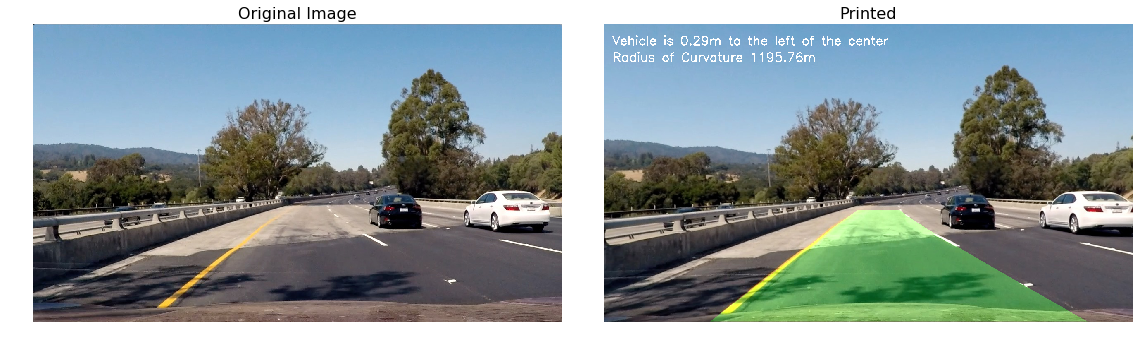

In [20]:
#\---> Calc cuvature and position example <-----------------------------------\#

# Load sample image 
original = mpimg.imread('test_images/test4.jpg')

# Transform to birds eye view
warped = pipeline(original)

# Find lane lines
(left_fitx, ploty, left_fit), (right_fitx, ploty, right_fit) = find_lines(warped)

# Calculate position and cuvature
curvature = np.sum((calc_curvature(left_fitx, ploty), calc_curvature(right_fitx, ploty)))/2
dist_from_center = calc_position(left_fit, right_fit, warped.shape)

# Print lane and data on the image
printed = print_lane(original, left_fit, right_fit)
printed = print_curvrad_position(printed, dist_from_center, curvature)

# Plot image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.tight_layout()

tit_ax1 = ax1.set_title('Original Image', fontsize=16)
ax1.imshow(original)
ax_axis = ax1.axis('off')

tit_ax2 = ax2.set_title('Printed', fontsize=16)
ax_img = ax2.imshow(printed)
ax_axis = ax2.axis('off')

fig.savefig('report-images/printed-image')

## Class and wrap-up function to process video

In [21]:
class Lines():
    def __init__(self):
        
        # Working params
        self.detected = False
        self.keep_n = 3
        
        # counter
        self.counter = 0
        
        # left line
        self.left_fitx = None
        self.left_fit = None
        self.lastn_left_fit = []

        # right line
        self.right_fitx = None
        self.right_fit = None
        self.lastn_right_fit = []
        
        # y
        self.fity = None  
        
        # Curvature and position
        self.position = None
        self.left_curverad = None
        self.right_curverad = None
        
        # last image processed
        self.warped = None
        
    def save_fit(self, left_line, right_line):
        # Save left line values
        self.left_fitx = left_line[0]
        self.fity = left_line[1]
        self.left_fit = left_line[2]
        if len(self.lastn_left_fit) > self.keep_n:
            self.lastn_left_fit.pop(0)
        self.lastn_left_fit.append(self.left_fit)
        
        # Save right line values        
        self.right_fitx = right_line[0]
        self.fity = right_line[1]
        self.right_fit = right_line[2]
        if len(self.lastn_right_fit) > self.keep_n:
            self.lastn_right_fit.pop(0)
        self.lastn_right_fit.append(self.right_fit)
        
    def get_fit(self):
        left_avrg = np.mean(self.lastn_left_fit, axis = 0)
        right_avrg = np.mean(self.lastn_right_fit, axis = 0)
        return left_avrg, right_avrg
        
    def transform_image(self, image):
        self.warped = pipeline(image)
    
    def find_lines(self, image):
        # Transform image
        self.transform_image(image)
        
        # Find lines
        if self.detected:
            left_line, right_line = find_lines_assisted(self.warped, self.left_fit, self.right_fit)
        else:
            left_line, right_line = find_lines(self.warped)
        
        # Update counter
        self.counter += 1
        
        # Save values
        self.detected = True
        self.save_fit(left_line, right_line)
        
        # Calc center deviation + curvature
        
    def update_curvature(self):
        # Set radius of curvature in meters
        self.left_curverad = calc_curvature(self.left_fitx, self.fity)
        self.right_curverad = calc_curvature(self.right_fitx, self.fity)
        
    def get_curvature(self):
        return self.left_curverad, self.right_curverad
    
    def update_position(self):
        # Set distance from center in meters
        self.position = calc_position(self.left_fit, self.right_fit, self.warped.shape)
        
    def get_position(self):
        return self.position

In [22]:
def full_image_pipeline(image):
    
    # Find lines
    lines.find_lines(image)
    
    # Get left and right fit coeff
    left_fit, right_fit = lines.get_fit()
    
    # Print lane
    printed = print_lane(image, left_fit, right_fit)
    
    # Print position and curvature (update only every 3 frames)
    if lines.counter % 3 == 1:
        lines.update_position()
        lines.update_curvature()
        
    curvature = np.sum(lines.get_curvature())/2
    dist_from_center = lines.get_position()
    
    result = print_curvrad_position(printed, dist_from_center, curvature)
    
    return result

In [23]:
lines = Lines()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(1,4)
white_clip = clip1.fl_image(full_image_pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [17:33<00:00,  1.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

